In [196]:
from rdflib import Graph, RDF, URIRef, Namespace
import numpy as np
from pandas import DataFrame
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# custom packages
import sys
sys.path.append( "../py" )
import collaboration

In [123]:
import importlib
importlib.reload(collaboration)

<module 'collaboration' from '../py/collaboration.py'>

In [3]:
g, ns = collaboration.parse_graph("../graph/experiment_graph.ttl", "turtle")

In [152]:
central_entity = "api_network:API" #entity for recommnsendation
entity1 = ("api_network:Mashup", "gr:include")
entity2 = ("foaf:OnlineAccount", "sioc:follows")
entity3 = ("skos:Concept", ["api_network:primaryCategory", "api_network:secondaryCategory"])
entity4 = ("xsd:string", "api-network:protocol")

In [5]:
User_API_df = collaboration.create_relatiobships_df(g, ns, entity2[0], central_entity, entity2[1])
Mahup_API_df = collaboration.create_relatiobships_df(g, ns, entity1[0], central_entity, entity1[1])

In [206]:
len(Mahup_API_df)

15758

In [170]:
Tag_API_df1 = collaboration.create_relatiobships_df(g, ns, central_entity, entity3[0], entity3[1][0])
Tag_API_df2 = collaboration.create_relatiobships_df(g, ns, central_entity, entity3[0], entity3[1][1])

In [172]:
Tag_API_df = pd.concat([Tag_API_df1, Tag_API_df2], ignore_index = True)

In [183]:
Tag_API_df = Tag_API_df.drop_duplicates()

In [207]:
len(Tag_API_df)

40992

In [6]:
API_legend, API_rev_legend = collaboration.create_legend_and_reversed_legend_from_graph(central_entity, g, ns)
Mashup_legend, Mashup_rev_legend = collaboration.create_legend_and_reversed_legend_from_graph(entity1[0], g, ns)
User_legend, user_rev_legend = collaboration.create_legend_and_reversed_legend_from_graph(entity2[0], g, ns)

In [185]:
Tag_legend, tag_rev_legend = collaboration.create_legend_and_reversed_legend_from_graph(entity3[0], g, ns)

###Evaluation###

In [199]:
User_API_dict = collaboration.create_relationship_dictionary(entity2[0], central_entity, User_legend, API_rev_legend, User_API_df)

In [25]:
msk = np.random.rand(len(User_API_df)) < 0.9

In [27]:
train_USER_API_df = User_API_df[msk]
test_USER_API_df = User_API_df[~msk]

In [29]:
train_API_User_dict = collaboration.create_relationship_dictionary(central_entity, entity2[0], API_legend, user_rev_legend, train_USER_API_df)
train_User_API_dict = collaboration.create_relationship_dictionary(entity2[0], central_entity, User_legend, API_rev_legend, train_USER_API_df)

In [49]:
test_User_API_dict = collaboration.create_relationship_dictionary(entity2[0], central_entity, User_legend, API_rev_legend, test_USER_API_df)

In [9]:
API_Mashup = collaboration.create_relationship_dictionary(central_entity, entity1[0], API_legend, Mashup_rev_legend, Mahup_API_df)
Mashup_API = collaboration.create_relationship_dictionary(entity1[0], central_entity, Mashup_legend, API_rev_legend, Mahup_API_df)

In [189]:
API_Tag = collaboration.create_relationship_dictionary(central_entity, entity3[0], API_legend, tag_rev_legend, Tag_API_df)
Tag_API = collaboration.create_relationship_dictionary(entity3[0], central_entity, Tag_legend, API_rev_legend, Tag_API_df)

In [128]:
NBI_API_User_Mashup = []
for u,value in test_User_API_dict.items():
    if value:
        #if value != mashup_api[m]:
        recomm = collaboration.three_layer_recommendation(u, train_User_API_dict, train_API_User_dict, Mashup_API, API_Mashup)
        for api in value:
            recommended_tuple = [i for i in recomm if i[0] == api]
            if recommended_tuple:
                NBI_API_User_Mashup.append(recomm.index(recommended_tuple[0])/len(recomm)) # 1491)#find position of test item in recommendation list
            else:
                NBI_API_User_Mashup.append(1)

In [191]:
NBI_API_User_Tag = []
for u,value in test_User_API_dict.items():
    if value:
        #if value != mashup_api[m]:
        recomm = collaboration.three_layer_recommendation(u, train_User_API_dict, train_API_User_dict, Tag_API, API_Tag)
        for api in value:
            recommended_tuple = [i for i in recomm if i[0] == api]
            if recommended_tuple:
                NBI_API_User_Tag.append(recomm.index(recommended_tuple[0])/len(recomm)) # 1491)#find position of test item in recommendation list
            else:
                NBI_API_User_Tag.append(1)

In [135]:
NBI_API_User = []
for u,value in test_User_API_dict.items():
    if value:
        #if value != mashup_api[m]:
        recomm = collaboration.two_layer_recommendation(train_User_API_dict[u], train_User_API_dict, train_API_User_dict)
        for api in value:
            recommended_tuple = [i for i in recomm if i[0] == api]
            if recommended_tuple:
                NBI_API_User.append(recomm.index(recommended_tuple[0])/len(recomm)) # 1491)#find position of test item in recommendation list
            else:
                NBI_API_User.append(1)

In [201]:
# GRM by number of followers
with_lengths = {}
for a,m in train_API_User_dict.items():
    with_lengths[a]=len(m)
sorted_apis = sorted(with_lengths.items(), key=operator.itemgetter(1), reverse=True)

GRM_result = []
for m,value in test_User_API_dict.items():
    if value != User_API_dict[m]:
        for api in value:
            recommended_tuple = [i for i in sorted_apis if i[0] == api]
            if recommended_tuple:
                GRM_result.append(sorted_apis.index(recommended_tuple[0])/len(sorted_apis)) # 1491)#
            else:
                GRM_result.append(1)

In [214]:
print(sorted_apis[0:10])
API_legend[13865]

[(5353, 2322), (6830, 1927), (13865, 1378), (7134, 1039), (12280, 873), (13134, 842), (1445, 744), (9261, 611), (4126, 526), (6700, 520)]


(13865, 'http://www.programmableweb.com/api/twitter')

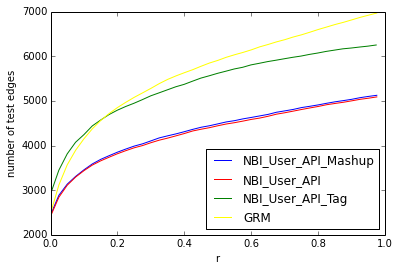

In [216]:
# evaluate the histogram
values, base = np.histogram([i for i in NBI_result if i != 1], bins=40)
values1, base1 = np.histogram([i for i in NBI_API_User if i != 1], bins=40)
values2, base2 = np.histogram([i for i in NBI_API_User_Tag if i != 1], bins=40)
values3, base3 = np.histogram([i for i in GRM_result if i != 1], bins=40)
#evaluate the cumulative
cumulative = np.cumsum(values)
cumulative1 = np.cumsum(values1)
cumulative2 = np.cumsum(values2)
cumulative3 = np.cumsum(values3)
# plot the cumulative function
plt.plot(base[:-1], cumulative, c='blue', label="NBI_User_API_Mashup") # Network Based Inference 3 layers
plt.plot(base1[:-1], cumulative1, c='red', label="NBI_User_API") # Network Based Inference 2 layers
plt.plot(base2[:-1], cumulative2, c='green', label="NBI_User_API_Tag") # Network Based Inference 2 layers
plt.plot(base3[:-1], cumulative3, c='yellow', label="GRM") # Global Ranking Method
plt.ylabel("number of test edges")
plt.xlabel("r")
plt.legend(loc=4)
№plt.savefig("NBI-performance")